# Synthetic time series example

This notebook demonstrates the synthetic time series query feature on open industrial data

In [1]:
from matplotlib import pyplot as plt
import os
from datetime import datetime
from getpass import getpass
from cognite.client.experimental import CogniteClient
from cognite.client.exceptions import *
project = 'publicdata'
api_key = os.environ.get('PUBLICDATA_API_KEY') or getpass("Open Industrial Data API-KEY: ")
client = CogniteClient(project=project,api_key=api_key,client_name="STS demo")

## In this tutorial, we will develop a simple synthetic time series for anomaly detection.

In [2]:
ts = client.time_series.retrieve_multiple(external_ids=['VAL_23-KA-9101-M01-62B:X.Value','VAL_23-TT-92602:X.Value'])
ts

,id,external_id,name,is_string,metadata,asset_id,is_step,description,created_time,last_updated_time
0,315296703512262,VAL_23-KA-9101-M01-62B:X.Value,VAL_23-KA-9101-M01-62B:X.Value,False,"{'tag': 'VAL_23-KA-9101-M01-62B:X.Value', 'sca...",5016064132476742,False,PH HV SWGR 1stStg Comp Mtr,0,0
1,329308713652215,VAL_23-TT-92602:X.Value,VAL_23-TT-92602:X.Value,False,"{'tag': 'VAL_23-TT-92602:X.Value', 'scan': '1'...",4893464693639605,False,PH 1stStgDiscCool Gas In,0,0


## We start with a simple linear regression model

In [3]:
df = client.datapoints.retrieve_dataframe(external_id=['VAL_23-KA-9101-M01-62B:X.Value','VAL_23-TT-92602:X.Value'],
                                  start=datetime(2019,10,1),end=datetime(2020,2,1),
                                  aggregates=['interpolation'],granularity='10s',complete='fill,dropna')

/home/sander/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


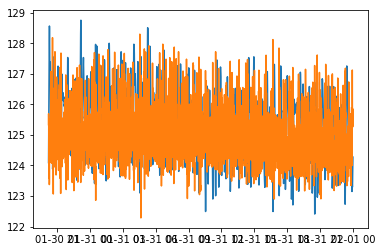

In [4]:
from scipy import stats
r = stats.linregress(df)
plt.plot(df.iloc[-10000:,1])
plt.plot(df.iloc[-10000:,0] * r.slope + r.intercept)

## We define the formula via sympy for convenience, avoiding the API syntax

In [5]:
from sympy import symbols
x,y = symbols(['x','y'])
y_pred = x * r.slope + r.intercept

In [6]:
error = 100 * abs(y - y_pred) / (abs(y) + 1e-6) # relative error in %

## let's test our query!

/home/sander/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
The Synthetic Timeseries API is currently experimental, so this functionality does not adhere to semantic versionining.
This means that this API may be subject to breaking changes even between patch versions.
You should NOT use the Synthetic Timeseries API in any production code.
  after removing the cwd from sys.path.


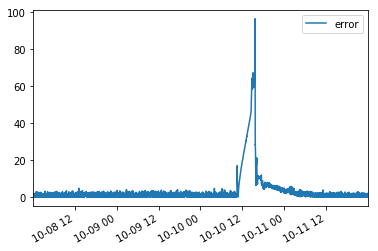

In [7]:
f = "TS{externalId:'sine'} + TS{externalId:'line'}"
dpt = client.datapoints.synthetic.retrieve(expression=error,
                                           variables={'x':ts[0],'y':ts[1]},
                                           start=datetime(2019,10,8),end=datetime(2019,10,12))
df = dpt.to_pandas()
df.columns = ['error']
df.plot()

In [ ]:
## Curiously we have found a period with high error in our model on the first try!